## The Dataset with text values are already labelized, so will be dropping all those columns 
## The following notebook was run on colab and then used in local computer to add comments
## Used Bayesian Optimization to get optimal parameters for RandomForestClassifier(RFC)
## Tried with XgBoost ,but the colab kept on disconnecting show memory error 
## The reason going with RFC and not with any crazy deep net is because,its labelled dataset with good number of features already defined,where a simple ensemble model is more than enough 

In [1]:
!pip install bayesian-optimization

In [5]:
file_name="globalterrorismdb_0718dist.xlsx"
import re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
df = pd.read_excel(file_name)

In [7]:
df.head(5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [8]:
len(df.columns)

135

### Explanation of each columns in the dataframe

https://www.start.umd.edu/gtd/downloads/Codebook.pdf



In [9]:
#Sum of all Missing values in each columns ,meaning that values are not represented at all
df.isnull().sum().sort_values(ascending=False).head(8)

gsubname3           181671
weapsubtype4_txt    181621
weapsubtype4        181621
weaptype4           181618
weaptype4_txt       181618
claimmode3          181558
claimmode3_txt      181558
gsubname2           181531
dtype: int64

In [10]:
#Dropping all those columns which have missing value more than 30% empty size .
#We then take it as a new dataframe 
df2=df.drop(df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False)>45000]
            .index,axis=1)

In [11]:
df2.head(5)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,NaN,...,NaN,1.0,0.0,0,0.0,PGIS,0,0,0,0
1,197000000002,1970,0,0,0,130,Mexico,1,North America,Federal,...,NaN,0.0,0.0,0,1.0,PGIS,0,1,1,1
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,Tarlac,...,NaN,1.0,0.0,0,0.0,PGIS,-9,-9,1,1
3,197001000002,1970,1,0,0,78,Greece,8,Western Europe,Attica,...,Unknown Explosive Type,NaN,NaN,1,0.0,PGIS,-9,-9,1,1
4,197001000003,1970,1,0,0,101,Japan,4,East Asia,Fukouka,...,NaN,NaN,NaN,1,0.0,PGIS,-9,-9,1,1


In [12]:
df2.isnull().sum() 
#We can see that they are still null values present ,we will remove these values as well(remove the 
#values which has these values) 


eventid                 0
iyear                   0
imonth                  0
iday                    0
extended                0
country                 0
country_txt             0
region                  0
region_txt              0
provstate             421
city                  434
latitude             4556
longitude            4557
specificity             6
vicinity                0
crit1                   0
crit2                   0
crit3                   0
doubtterr               1
multiple                1
success                 0
suicide                 0
attacktype1             0
attacktype1_txt         0
targtype1               0
targtype1_txt           0
targsubtype1        10373
targsubtype1_txt    10373
corp1               42550
target1               636
natlty1              1559
natlty1_txt          1559
gname                   0
guncertain1           380
individual              0
weaptype1               0
weaptype1_txt           0
weapsubtype1        20768
weapsubtype1

In [13]:
df2.dropna(inplace=True)

In [14]:
df2.head(5)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,Unknown Gun Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,Automatic or Semi-Automatic Rifle,0.0,0.0,0,0.0,PGIS,0,0,0,0
7,197001020002,1970,1,2,0,217,United States,1,North America,California,...,Unknown Explosive Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,Molotov Cocktail/Petrol Bomb,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0
9,197001030001,1970,1,3,0,217,United States,1,North America,Wisconsin,...,Gasoline or Alcohol,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0


In [15]:
df2.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude',
       'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt',
       'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nwound', 'property',
       'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

In [16]:
columns=['iyear', 'imonth', 'iday', 'extended', 'country',
         'region', 'latitude', 'longitude','success', 
         'suicide','attacktype1', 'targtype1', 
          'natlty1',
         'weaptype1' ,'nkill',
         'multiple', 'individual','city','provstate',
          'property','gname','natlty1'
        ]
#We won't be adding any txt columns either as the categorical values are already represented

In [17]:
df2=df2[columns]

Target variable is gname(the group responsible for the terror attack) , we will find the total number of classes(groups) present and also we will check the most common values present in the dataset

In [18]:
target = df2['gname']
gcount = Counter(target)
print('No. of groups = {}'.format(len(gcount)))

No. of groups = 2212


In [19]:
g1 = gcount.most_common(1)[0]
print('Most common group, {} = {:.4f}%'.format(g1[0], 100 * g1[1] / target.size))
gcount.most_common(5)

Most common group, Unknown = 49.2577%


[('Unknown', 52491),
 ('Taliban', 5029),
 ('Islamic State of Iraq and the Levant (ISIL)', 3823),
 ('Al-Shabaab', 1951),
 ('Shining Path (SL)', 1900)]

In [20]:
x,y=[],[]
for i ,j in list(gcount.most_common()[0:25]):
    y.append(j)
    try:
        x.append(re.search(r'\(.+\)',i).group().strip("()"))
    except:
        x.append(i)
#To get the values present in paranthesis so that plot looks better

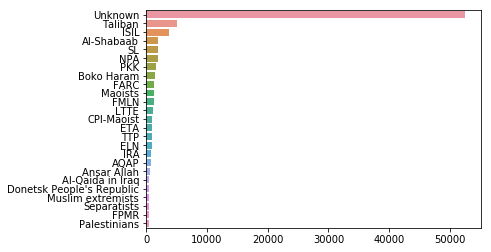

In [21]:
sns.barplot(y,x)

In [22]:
df2["gname"]=df2["gname"].str.replace("'",' ')
greater_group_values=df2['gname'].value_counts().sort_values(ascending = False)>150

In [23]:
df3=df2.loc[df2["gname"].isin(greater_group_values.index)]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106564 entries, 5 to 181689
Data columns (total 22 columns):
iyear          106564 non-null int64
imonth         106564 non-null int64
iday           106564 non-null int64
extended       106564 non-null int64
country        106564 non-null int64
region         106564 non-null int64
latitude       106564 non-null float64
longitude      106564 non-null float64
success        106564 non-null int64
suicide        106564 non-null int64
attacktype1    106564 non-null int64
targtype1      106564 non-null int64
natlty1        106564 non-null float64
weaptype1      106564 non-null int64
nkill          106564 non-null float64
multiple       106564 non-null float64
individual     106564 non-null int64
city           106564 non-null object
provstate      106564 non-null object
property       106564 non-null int64
gname          106564 non-null object
natlty1        106564 non-null float64
dtypes: float64(6), int64(13), object(3)
memory usage: 18.7+

In [24]:
labelencoder = LabelEncoder()
df3["y"]=pd.Series(labelencoder.fit_transform(df3['gname']))

In [25]:
df3["y"]

5         1149.0
6         2142.0
7         1149.0
8          300.0
9          435.0
11         435.0
12         435.0
13         435.0
14        1909.0
17         435.0
18         435.0
19         435.0
20        1149.0
22        1909.0
23        2142.0
24        1149.0
29         435.0
30        2173.0
31         323.0
32         323.0
33        1909.0
35         323.0
38        1905.0
40         435.0
41        1149.0
42        1909.0
43        2142.0
44        1149.0
45        2142.0
47        1909.0
           ...  
181652       NaN
181653       NaN
181657       NaN
181658       NaN
181659       NaN
181660       NaN
181661       NaN
181663       NaN
181664       NaN
181665       NaN
181668       NaN
181669       NaN
181671       NaN
181672       NaN
181673       NaN
181675       NaN
181676       NaN
181677       NaN
181678       NaN
181679       NaN
181680       NaN
181681       NaN
181682       NaN
181683       NaN
181684       NaN
181685       NaN
181686       NaN
181687       N

In [28]:
df3["ncity"]=labelencoder.fit_transform(df3['city'])
df3['nprovstate'] = labelencoder.fit_transform(df3['provstate'])
df4=df3.drop(['city','provstate',"gname"],axis=1)
df4.columns=['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'latitude',
       'longitude', 'success', 'suicide', 'attacktype1', 'targtype1',
       'natlty1', 'weaptype1', 'nkill', 'multiple', 'individual', 'property',
       'natlty1', 'ncity', 'nprovstate','y']
##As mentioned above ,all the text_columns are removed and the columns decided are from the documentation which states 
##what each column represents 

In [29]:
len(df4.columns)

22

In [30]:
X = df4.iloc[:, 0:20].values
y = df4.iloc[:, -1].values

##All the Features are taken as X and the last value,which is the label is taken as Y

In [31]:
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis=0)
imputer = imputer.fit(X)
X = imputer.transform(X)

In [32]:
X_train, X_test , y_train , y_test = train_test_split(X, y , test_size=0.4, random_state = 0)

In [9]:
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}


def rfccv(n_estimators, min_samples_split, max_features,max_leaf_nodes):
  classifier= RFC(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=2,max_leaf_nodes= int(max_leaf_nodes),verbose=2,n_jobs=-1)
  classifier.fit( X_train,y_train)
  accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
         
  return accuracies.mean()



gp_params = {"alpha": 1e-5}

rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (70, 90),
        'min_samples_split': (14, 20),
        'max_features': (0.7, 0.999),
        'max_leaf_nodes':(7000,9000)}
    )
rfcBO.maximize(n_iter=8, **gp_params)

Initialization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   max_leaf_nodes |   min_samples_split |   n_estimators | 
building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.8s


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.6s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.8s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.4s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.2s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.9s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.3s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.3s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.9s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.4s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.7s finished


    1 | 26m36s |    0.93958 |         0.7786 |        7882.8468 |             17.5053 |        82.0286 | 
building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74building tree 4 of 74

building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.3s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    4.8s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    6.5s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    6.0s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.8s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.5s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.9s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.9s finished


building tree 1 of 74building tree 2 of 74

building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    6.0s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.3s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    5.3s finished


    2 | 24m54s |    0.93841 |         0.8402 |        7922.9077 |             18.3580 |        74.8563 | 
building tree 1 of 88building tree 2 of 88

building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 58 of 88building tree 57 of 88

building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.3s


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    5.3s finished


building tree 1 of 88building tree 2 of 88

building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.3min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.2s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 20 of 88
building tree 19 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.0s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.8s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 40 of 88building tree 39 of 88

building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.4s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.5s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.3s finished


building tree 1 of 88building tree 2 of 88

building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.4s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.1s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.4s finished


    3 | 26m52s |    0.93909 |         0.7271 |        8151.9010 |             17.1881 |        88.5889 | 
building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.0s


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    5.4s finished


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    7.5s finished


building tree 1 of 87building tree 2 of 87

building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.8s finished


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    7.3s finished


building tree 1 of 87building tree 2 of 87

building tree 3 of 87building tree 4 of 87

building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    7.1s finished


building tree 1 of 87building tree 2 of 87

building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.5s finished


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.5s finished


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.3s finished


building tree 1 of 87
building tree 2 of 87
building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.6s finished


building tree 1 of 87building tree 2 of 87

building tree 3 of 87
building tree 4 of 87
building tree 5 of 87
building tree 6 of 87
building tree 7 of 87
building tree 8 of 87
building tree 9 of 87
building tree 10 of 87
building tree 11 of 87
building tree 12 of 87
building tree 13 of 87
building tree 14 of 87
building tree 15 of 87
building tree 16 of 87
building tree 17 of 87
building tree 18 of 87
building tree 19 of 87
building tree 20 of 87
building tree 21 of 87
building tree 22 of 87
building tree 23 of 87
building tree 24 of 87
building tree 25 of 87
building tree 26 of 87
building tree 27 of 87
building tree 28 of 87
building tree 29 of 87
building tree 30 of 87
building tree 31 of 87
building tree 32 of 87
building tree 33 of 87
building tree 34 of 87
building tree 35 of 87
building tree 36 of 87
building tree 37 of 87
building tree 38 of 87


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 87
building tree 40 of 87
building tree 41 of 87
building tree 42 of 87
building tree 43 of 87
building tree 44 of 87
building tree 45 of 87
building tree 46 of 87
building tree 47 of 87
building tree 48 of 87
building tree 49 of 87
building tree 50 of 87
building tree 51 of 87
building tree 52 of 87
building tree 53 of 87
building tree 54 of 87
building tree 55 of 87
building tree 56 of 87
building tree 57 of 87
building tree 58 of 87
building tree 59 of 87
building tree 60 of 87
building tree 61 of 87
building tree 62 of 87
building tree 63 of 87
building tree 64 of 87
building tree 65 of 87
building tree 66 of 87
building tree 67 of 87
building tree 68 of 87
building tree 69 of 87
building tree 70 of 87
building tree 71 of 87
building tree 72 of 87
building tree 73 of 87
building tree 74 of 87
building tree 75 of 87
building tree 76 of 87
building tree 77 of 87
building tree 78 of 87
building tree 79 of 87
building tree 80 of 87
building tree 81 of 87
building tr

[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:  2.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  87 out of  87 | elapsed:    6.5s finished


    4 | 29m16s |    0.93852 |         0.8095 |        7520.0129 |             18.3317 |        87.8367 | 
building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.7s


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.6s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    7.1s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    7.0s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.7s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 32 of 82building tree 31 of 82

building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.7s finished


building tree 1 of 82
building tree 2 of 82
building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.7s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.9s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 6 of 82
building tree 5 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    6.3s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.7s finished


building tree 1 of 82building tree 2 of 82

building tree 3 of 82
building tree 4 of 82
building tree 5 of 82
building tree 6 of 82
building tree 7 of 82
building tree 8 of 82
building tree 9 of 82
building tree 10 of 82
building tree 11 of 82
building tree 12 of 82
building tree 13 of 82
building tree 14 of 82
building tree 15 of 82
building tree 16 of 82
building tree 17 of 82
building tree 18 of 82
building tree 19 of 82
building tree 20 of 82
building tree 21 of 82
building tree 22 of 82
building tree 23 of 82
building tree 24 of 82
building tree 25 of 82
building tree 26 of 82
building tree 27 of 82
building tree 28 of 82
building tree 29 of 82
building tree 30 of 82
building tree 31 of 82
building tree 32 of 82
building tree 33 of 82
building tree 34 of 82
building tree 35 of 82
building tree 36 of 82
building tree 37 of 82
building tree 38 of 82


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 82
building tree 40 of 82
building tree 41 of 82
building tree 42 of 82
building tree 43 of 82
building tree 44 of 82
building tree 45 of 82
building tree 46 of 82
building tree 47 of 82
building tree 48 of 82
building tree 49 of 82
building tree 50 of 82
building tree 51 of 82
building tree 52 of 82
building tree 53 of 82
building tree 54 of 82
building tree 55 of 82
building tree 56 of 82
building tree 57 of 82
building tree 58 of 82
building tree 59 of 82
building tree 60 of 82
building tree 61 of 82
building tree 62 of 82
building tree 63 of 82
building tree 64 of 82
building tree 65 of 82
building tree 66 of 82
building tree 67 of 82
building tree 68 of 82
building tree 69 of 82
building tree 70 of 82
building tree 71 of 82
building tree 72 of 82
building tree 73 of 82
building tree 74 of 82
building tree 75 of 82
building tree 76 of 82
building tree 77 of 82
building tree 78 of 82
building tree 79 of 82
building tree 80 of 82
building tree 81 of 82
building tr

[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  82 out of  82 | elapsed:    5.7s finished


    5 | 28m11s |    0.94319 |         0.8424 |        7337.8595 |             14.6804 |        82.9361 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   max_leaf_nodes |   min_samples_split |   n_estimators | 
building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
bui

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.5s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    4.6s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.9s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71building tree 26 of 71

building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    6.1s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.6s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.3s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.3s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.1s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.5s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    5.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    4.9s finished


    6 | 27m58s |    0.93676 |         0.9974 |        7000.4255 |             17.6970 |        71.2884 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    4.3s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70building tree 36 of 70

building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.9s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70building tree 36 of 70

building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.5s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.5s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.3s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70building tree 6 of 70

building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.4s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.0s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    4.9s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    4.8s finished


    7 | 24m20s |    0.94298 |         0.8204 |        8999.7376 |             14.2211 |        70.6357 | 
building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  3.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.8s


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    5.7s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.8min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.6s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89building tree 8 of 89

building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.2s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.8s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.0s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.9s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.0s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.3s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.3s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  3.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.7s finished


    8 | 33m07s |    0.94274 |         0.8920 |        8999.5330 |             14.5317 |        89.2979 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 40 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.9s


building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    4.9s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.1s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.9s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.4s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.5s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.8s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.8s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.0min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.7s finished


    9 | 22m55s |    0.94274 |         0.7261 |        8999.8889 |             14.3195 |        70.2092 | 
building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.5s


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    5.5s finished


building tree 1 of 88building tree 2 of 88

building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.6s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.4s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.4s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    7.2s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.9s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.9s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.8s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 22 of 88
building tree 21 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.8s finished


building tree 1 of 88
building tree 2 of 88
building tree 3 of 88
building tree 4 of 88
building tree 5 of 88
building tree 6 of 88
building tree 7 of 88
building tree 8 of 88
building tree 9 of 88
building tree 10 of 88
building tree 11 of 88
building tree 12 of 88
building tree 13 of 88
building tree 14 of 88
building tree 15 of 88
building tree 16 of 88
building tree 17 of 88
building tree 18 of 88
building tree 19 of 88
building tree 20 of 88
building tree 21 of 88
building tree 22 of 88
building tree 23 of 88
building tree 24 of 88
building tree 25 of 88
building tree 26 of 88
building tree 27 of 88
building tree 28 of 88
building tree 29 of 88
building tree 30 of 88
building tree 31 of 88
building tree 32 of 88
building tree 33 of 88
building tree 34 of 88
building tree 35 of 88
building tree 36 of 88
building tree 37 of 88
building tree 38 of 88


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 88
building tree 40 of 88
building tree 41 of 88
building tree 42 of 88
building tree 43 of 88
building tree 44 of 88
building tree 45 of 88
building tree 46 of 88
building tree 47 of 88
building tree 48 of 88
building tree 49 of 88
building tree 50 of 88
building tree 51 of 88
building tree 52 of 88
building tree 53 of 88
building tree 54 of 88
building tree 55 of 88
building tree 56 of 88
building tree 57 of 88
building tree 58 of 88
building tree 59 of 88
building tree 60 of 88
building tree 61 of 88
building tree 62 of 88
building tree 63 of 88
building tree 64 of 88
building tree 65 of 88
building tree 66 of 88
building tree 67 of 88
building tree 68 of 88
building tree 69 of 88
building tree 70 of 88
building tree 71 of 88
building tree 72 of 88
building tree 73 of 88
building tree 74 of 88
building tree 75 of 88
building tree 76 of 88
building tree 77 of 88
building tree 78 of 88
building tree 79 of 88
building tree 80 of 88
building tree 81 of 88
building tr

[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  88 out of  88 | elapsed:    6.8s finished


   10 | 29m26s |    0.93949 |         0.7952 |        8999.9294 |             17.9749 |        88.9471 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    4.9s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.6s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    6.0s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.8s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.8s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.7s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.6s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.5s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    5.2s finished


   11 | 28m50s |    0.93901 |         0.9580 |        8999.3873 |             15.3129 |        70.1052 | 
building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.0s


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.1s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89building tree 4 of 89

building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 36 of 89building tree 35 of 89

building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.4s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.2s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89
building tree 39 of 89
building tree 40 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tree 82 of 89
building tree 83 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.9s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.9s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.6s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.6s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.9s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.6s finished


building tree 2 of 89building tree 1 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.4s finished


   12 | 28m49s |    0.94294 |         0.7324 |        8999.6447 |             14.9436 |        89.5789 | 
building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89
building tree 39 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tree 82 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.3s


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.2s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89building tree 4 of 89

building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    8.3s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    8.0s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.8s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.2s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.8s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.9s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89building tree 50 of 89

building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    7.3s finished


building tree 1 of 89building tree 2 of 89

building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.6s finished


building tree 1 of 89
building tree 2 of 89
building tree 3 of 89
building tree 4 of 89
building tree 5 of 89
building tree 6 of 89
building tree 7 of 89
building tree 8 of 89
building tree 9 of 89
building tree 10 of 89
building tree 11 of 89
building tree 12 of 89
building tree 13 of 89
building tree 14 of 89
building tree 15 of 89
building tree 16 of 89
building tree 17 of 89
building tree 18 of 89
building tree 19 of 89
building tree 20 of 89
building tree 21 of 89
building tree 22 of 89
building tree 23 of 89
building tree 24 of 89
building tree 25 of 89
building tree 26 of 89
building tree 27 of 89
building tree 28 of 89
building tree 29 of 89
building tree 30 of 89
building tree 31 of 89
building tree 32 of 89
building tree 33 of 89
building tree 34 of 89
building tree 35 of 89
building tree 36 of 89
building tree 37 of 89
building tree 38 of 89


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min


building tree 39 of 89
building tree 40 of 89
building tree 41 of 89
building tree 42 of 89
building tree 43 of 89
building tree 44 of 89
building tree 45 of 89
building tree 46 of 89
building tree 47 of 89
building tree 48 of 89
building tree 49 of 89
building tree 50 of 89
building tree 51 of 89
building tree 52 of 89
building tree 53 of 89
building tree 54 of 89
building tree 55 of 89
building tree 56 of 89
building tree 57 of 89
building tree 58 of 89
building tree 59 of 89
building tree 60 of 89
building tree 61 of 89
building tree 62 of 89
building tree 63 of 89
building tree 64 of 89
building tree 65 of 89
building tree 66 of 89
building tree 67 of 89
building tree 68 of 89
building tree 69 of 89
building tree 70 of 89
building tree 71 of 89
building tree 72 of 89
building tree 73 of 89
building tree 74 of 89
building tree 75 of 89
building tree 76 of 89
building tree 77 of 89
building tree 78 of 89
building tree 79 of 89
building tree 80 of 89
building tree 81 of 89
building tr

[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:  2.5min finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  89 out of  89 | elapsed:    6.7s finished


   13 | 28m18s |    0.93846 |         0.7104 |        8999.8175 |             18.8212 |        89.8161 | 


In [4]:
classifier=RFC(max_features=0.5496, max_leaf_nodes=6010, min_samples_split=15,n_estimators=48,verbose=2,n_jobs=-1)
classifier.fit(X_train,y_train)

building tree 1 of 48building tree 2 of 48

building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.3s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5496, max_leaf_nodes=6010,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=48, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [15]:
y_pred = classifier.predict(X_test)  
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   17.8s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:   23.1s finished


             precision    recall  f1-score   support

          2       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         3
          5       0.54      1.00      0.70         7
          6       0.50      0.33      0.40         3
          7       0.00      0.00      0.00         1
          8       0.92      1.00      0.96        11
          9       0.00      0.00      0.00         1
         10       0.00      0.00      0.00         1
         11       0.92      1.00      0.96        11
         12       0.98      1.00      0.99        91
         14       1.00      0.76      0.87        17
         15       0.78      0.85      0.81        33
         16       0.57      0.73      0.64        11
         17       0.00      0.00      0.00         1
         18       0.00      0.00      0.00         1
         20       0.96      0.96      0.96        28
         21       0.93      0.88      0.90        43
         22       0.99      1.00      1.00   

In [8]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')

building tree 1 of 48building tree 2 of 48

building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 12 of 48
building tree 11 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.9s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   38.3s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.2s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.2s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   57.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    4.1s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.1s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   58.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.9s finished


building tree 1 of 48building tree 2 of 48

building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.6s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   58.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.7s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.0s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   58.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.6s finished


building tree 1 of 48building tree 2 of 48

building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.4s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   58.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.5s finished


building tree 1 of 48building tree 2 of 48

building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.7s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   59.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.4s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.5s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   58.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.3s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 32 of 48
building tree 31 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.9s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   59.3s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.3s finished


building tree 1 of 48
building tree 2 of 48
building tree 3 of 48
building tree 4 of 48
building tree 5 of 48
building tree 6 of 48
building tree 7 of 48
building tree 8 of 48
building tree 9 of 48
building tree 10 of 48
building tree 11 of 48
building tree 12 of 48
building tree 13 of 48
building tree 14 of 48
building tree 15 of 48
building tree 16 of 48
building tree 17 of 48
building tree 18 of 48
building tree 19 of 48
building tree 20 of 48
building tree 21 of 48
building tree 22 of 48
building tree 23 of 48
building tree 24 of 48
building tree 25 of 48
building tree 26 of 48
building tree 27 of 48
building tree 28 of 48
building tree 29 of 48
building tree 30 of 48
building tree 31 of 48
building tree 32 of 48
building tree 33 of 48
building tree 34 of 48
building tree 35 of 48
building tree 36 of 48
building tree 37 of 48
building tree 38 of 48


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.0s


building tree 39 of 48
building tree 40 of 48
building tree 41 of 48
building tree 42 of 48
building tree 43 of 48
building tree 44 of 48
building tree 45 of 48
building tree 46 of 48
building tree 47 of 48
building tree 48 of 48


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   59.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    3.2s finished


In [16]:
print(accuracies.mean())
print(accuracies.std())

0.9369978430552462
0.04673279344891854


In [28]:
classifier.predict(X_test[0].reshape(1,20))

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    0.0s finished


array([189])

In [29]:
classifier.predict(X_test[1].reshape(1,20))

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    0.0s finished


array([185])

In [30]:
classifier.predict(X_test[2].reshape(1,20))

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:    0.0s finished


array([1529])